# Deep dream 

Visualization technique that made Prism possible

http://genekogan.com/works/style-transfer/


[![genekogan](resources/style_transfer_genekogan.png)](http://genekogan.com/images/style-transfer/picasso-periods.mp4 "Genekogan")

## Wait but how?

1. Maths,maths and some more maths 
2. Serendipity: Good accidents do happen 
3. Visualization of regular classification networks

## Recipy for a dream

1. Train your network on a classification problem
2. Choose Neuron that you want to be activated more in your new "halucinated" image
3. Change your image to maximize activation on that neuron
4. Repeat 3. till you are happy

### Train your network on a classifcation problem

#### ImageNet

We use pretrained VGG16 network (top5 accuracy 90%)

In [1]:
from keras.applications.vgg16 import VGG16
from keras.applications.imagenet_utils import preprocess_input,decode_predictions
from keras.preprocessing import image as img_utils
from keras.layers import Input

# this will contain our generated image
img_size = (224, 224, 3)
input_template = Input(batch_shape=(1,) + img_size)

img_recognition_network = VGG16(input_tensor=input_template, 
                                weights='imagenet', 
                                include_top=True)

Using TensorFlow backend.


In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys,os,glob
import numpy as np
sys.path.append('/home/jakub/projects/deep_learning_art_webinar')
import utils

Some random images from the internet

In [ ]:
from ipywidgets import interact

## Lets Dream 

In [68]:
layer_nr = 11
filter_nr = 16
coeff = 0.001
jitter = 10

layer_dict = utils.get_layer_dict(img_recognition_network)

x = layer_dict[layer_nr].output[:,:,:,filter_nr]
shape = layer_dict[layer_nr].output_shape[:3]

loss =  - coeff * K.sum(K.square(x))

grads = K.gradients(loss, input_template)


f_outputs = K.function([input_template], [loss] + grads)

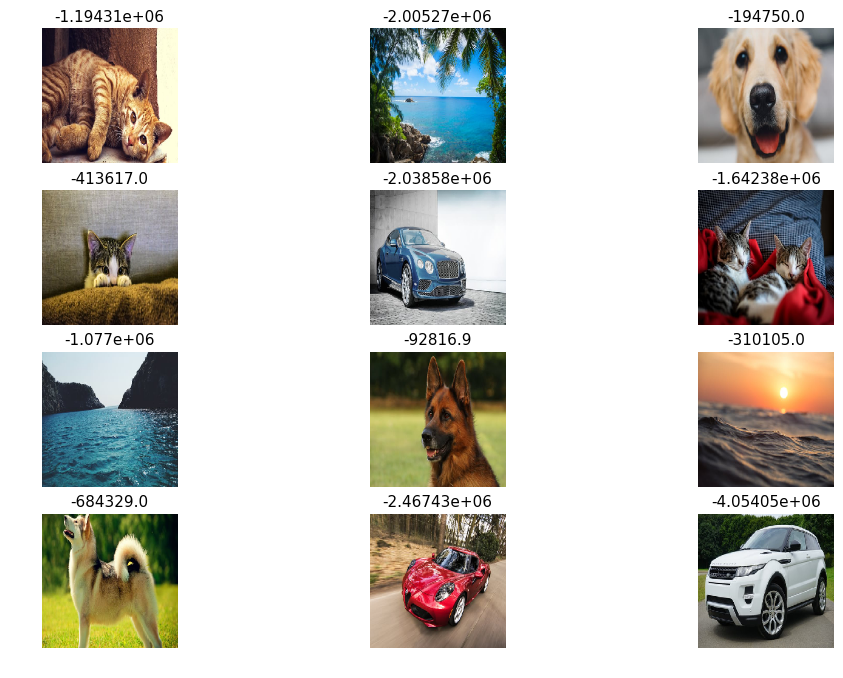

In [63]:
def get_loss_on_img(img_tensor):
    loss_fun = K.function([input_template], [loss])
    loss_val = loss_fun([img_tensor])
    return loss_val[0]

losses = [get_loss_on_img(im_t) for im_t in img_tensors_list] 

utils.plot_list(img_list,labels=losses)  

In [64]:
def eval_loss_and_grads(x):
    x = x.reshape((1,) + img_size)
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')

    return loss_value, grad_values

class Evaluator(object):
    def __init__(self):
        self.loss_value = None
        self.grad_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

('Current loss value:', -4251296.0)


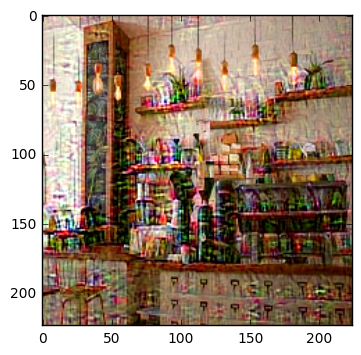

('Current loss value:', -24542382.0)


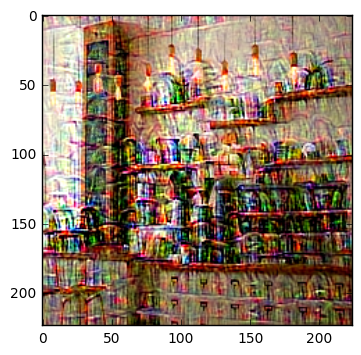

('Current loss value:', -86269568.0)


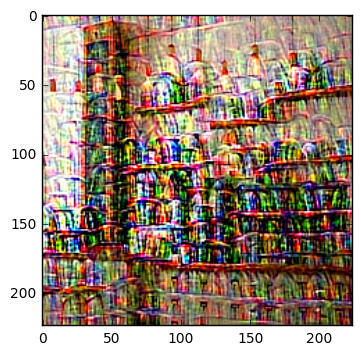

('Current loss value:', -2.1709966e+08)


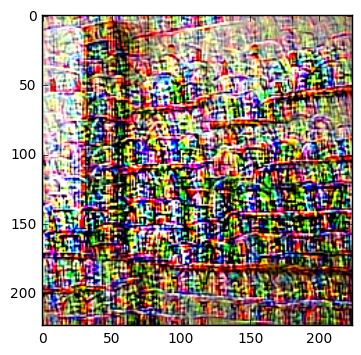

KeyboardInterrupt: 

In [69]:
from scipy.optimize import fmin_l_bfgs_b
from matplotlib import pyplot as plt

evaluator = Evaluator()

img_dream = img_utils.load_img("resources/shop.jpeg",target_size = img_size[:2])
x = utils.img2vggtensor(img_dream) 

for i in range(15):

    random_jitter = (jitter * 2) * (np.random.random(img_size) - 0.5)
    x += random_jitter

    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=7)
    print('Current loss value:', min_val)
    
    x = x.reshape(img_size)
    x -= random_jitter
    img = utils.deprocess_image(np.copy(x))
    
    plt.imsave(os.path.join("results","shop_{}_{}_{}_{}_{}.jpg".\
                            format(layer_nr,
                                   filter_nr,
                                   coeff,
                                   jitter,
                                   i
                                  )),img)
    plt.imshow(img)
    plt.show()